In [40]:
from __future__ import annotations

import sys
import traceback
from pathlib import Path
from typing import Any, List

import numpy as np
import pandas as pd  # type: ignore[import]

In [41]:
model_choice = "pmh_model"

In [42]:
PROJECT_ROOT = Path.cwd().resolve()
if not (PROJECT_ROOT / "src").is_dir():
    PROJECT_ROOT = PROJECT_ROOT.parent
SRC_ROOT = PROJECT_ROOT / "src"
DATA_ROOT = PROJECT_ROOT / "data" / "processed"

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print(f"Using project root: {PROJECT_ROOT}")
print(f"Data directory: {DATA_ROOT}")

Using project root: D:\Research\nips_reviewing\CategoryLearning\StateBased\CategoryLearning
Data directory: D:\Research\nips_reviewing\CategoryLearning\StateBased\CategoryLearning\data\processed


In [43]:
from src.Bayesian_state.utils.load_config import MODEL_STRUCT  # type: ignore[import]
# from src.Bayesian_state.problems import StateModel  # type: ignore[import]
# Use local import to avoid circular dependency if needed, or rely on the fix in state_grid_optimizer.py
from src.Bayesian_state.problems import StateModel

print(f"Available model structures: {list(MODEL_STRUCT.keys())}")

Available model structures: ['base_model', 'default_model', 'm_model', 'pmh_model', 'pm_model', 'p_model']


In [44]:
def build_subject_dataset(subject_id: int) -> tuple[np.ndarray, np.ndarray, np.ndarray, int]:
    """Load Task2 data and return arrays for a single subject."""
    task2_path = DATA_ROOT / "Task2_processed.csv"
    if not task2_path.exists():
        raise FileNotFoundError(f"Missing processed dataset: {task2_path}")

    learning_data = pd.read_csv(task2_path)
    subject_data = learning_data[learning_data["iSub"] == subject_id]
    if subject_data.empty:
        raise ValueError(f"Subject {subject_id} not found in Task2 dataset")

    condition = int(subject_data["condition"].iloc[0])
    stimulus = subject_data[["feature1", "feature2", "feature3", "feature4"]].to_numpy(dtype=float)
    choices = subject_data["choice"].to_numpy(dtype=float)
    feedback = subject_data["feedback"].to_numpy(dtype=float)

    return stimulus, choices, feedback, condition


def make_trial_sequence(stimulus: np.ndarray, choices: np.ndarray, feedback: np.ndarray, max_trials: int = 20) -> List[List[Any]]:
    """Assemble the per-trial list expected by StateModel.fit_step_by_step."""
    usable = min(len(stimulus), max_trials)
    trials: List[List[Any]] = []
    for idx in range(usable):
        trial: List[Any] = [stimulus[idx], int(choices[idx]), float(feedback[idx])]
        trials.append(trial)
    return trials

In [45]:
subject_id = 15

try:
    stimulus, choices, feedback, condition = build_subject_dataset(subject_id)
except Exception as exc:  # noqa: BLE001
    print("Dataset preparation failed:", exc)
    traceback.print_exc()
    raise

print(f"Loaded subject {subject_id} with {len(stimulus)} trials (condition {condition}).")
print("First stimulus row:", stimulus[0])
print("Choice / feedback samples:", choices[:3], feedback[:3])
print("Condition", condition)

Loaded subject 15 with 384 trials (condition 3).
First stimulus row: [0.22878328 0.73217257 0.38135291 0.20531656]
Choice / feedback samples: [3. 3. 3.] [0. 0. 1.]
Condition 3


In [46]:
from copy import deepcopy

engine_config = deepcopy(MODEL_STRUCT.get(model_choice))

if engine_config is None:
    raise KeyError(f"{model_choice} configuration not found in MODEL_STRUCT")

# DEBUG CONFIG
hypo_debug = False
if "modules" in engine_config and "hypo_transitions_mod" in engine_config["modules"]:
    engine_config["modules"]["hypo_transitions_mod"]["kwargs"]['hypothesis_debug'] = hypo_debug

try:
    model = StateModel(
        engine_config,
        condition=condition,
        subject_id=subject_id,
        processed_data_dir=DATA_ROOT,
    )
except Exception as exc:
    print("StateModel construction failed:", exc)
    traceback.print_exc()
    raise

print("StateModel initialised successfully.")

INFO:cat-learning:  - Module 'perception_mod' registered as 'self.perception_mod'.
INFO:cat-learning:  - Module 'hypo_transitions_mod' registered as 'self.hypo_transitions_mod'.
INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
D:\Research\nips_reviewing\CategoryLearning\StateBased\CategoryLearning\src\Bayesian_state\problems\modules\memory.py:223: RuntimeWarning: divide by zero encountered in log
  return np.log(clipped)
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


{'perception_mod': {'class': 'src.Bayesian_state.problems.modules.perception.PerceptionModule', 'kwargs': {'mean': [-0.008987819671576303, -0.0013484044997005968, -0.011365922117348408, 0.003650995494801886], 'std': [0.04239360199674432, 0.042689185630535434, 0.03891249493377415, 0.017350713684618067], 'subject_id': 15}}, 'hypo_transitions_mod': {'class': 'src.Bayesian_state.problems.modules.hypo_transitions.DynamicHypothesisModule', 'kwargs': {'strategies': 'original_strategies_b', 'init_num': 8, 'hypothesis_debug': False}}, 'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 10.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.05, 'gamma': 0.9}}}
name: perception_mod mod_kwargs: {'mean': [-0.008987819671576303, -0.0013484044997005968, -0.011365922117348408, 0.003650995494801886], 'std': [0.04239360199674432, 0.042689185630535434, 0.03891249493377415, 0.0173507136

In [47]:
trial_sequence = make_trial_sequence(stimulus, choices, feedback, max_trials=100000)
print(f"Prepared {len(trial_sequence)} trials for inference.")
print("Example trial:", trial_sequence[0])

Prepared 384 trials for inference.
Example trial: [array([0.22878328, 0.73217257, 0.38135291, 0.20531656]), 3, 0.0]


In [48]:
try:
    posterior_log, prior_log = model.fit_step_by_step(trial_sequence)
except Exception as exc:
    print("fit_step_by_step raised an exception:", exc)
    traceback.print_exc()
    raise


In [49]:
# 打印 posterior 最大的 5 个 hypo index 以及他们的 similarity
post_sum_hypo = np.sum(posterior_log, axis=0)
top5_indices = np.argsort(post_sum_hypo)[-5:][::-1]
print(top5_indices)
# similarity
similarity_matrix = model.engine.partition.similarity_matrix
similarity_matrix_5 = similarity_matrix[top5_indices][:, top5_indices]
similarity_matrix_5

[42 94 92 55 24]


array([[1.     , 0.76066, 0.55361, 0.68988, 0.70919],
       [0.76066, 1.     , 0.55469, 0.55801, 0.58246],
       [0.55361, 0.55469, 1.     , 0.35539, 0.47395],
       [0.68988, 0.55801, 0.35539, 1.     , 0.57993],
       [0.70919, 0.58246, 0.47395, 0.57993, 1.     ]])

In [50]:
# 从 hypo_transitions 模块收集每个策略在每个 trial 选中的 hypo 数量（若模块缺失则跳过）
hypo_mod = None
if hasattr(model, "engine") and hasattr(model.engine, "modules") and isinstance(model.engine.modules, dict):
    hypo_mod = model.engine.modules.get("hypo_transitions_mod")

has_strategy_counts = False
strategy_counts: dict[str, list[int]] = {}
active_total: list[int] = []
trial_axis: np.ndarray = np.arange(len(posterior_log))

if hypo_mod is not None and hasattr(hypo_mod, "strategy_counts_log"):
    strategy_log = hypo_mod.strategy_counts_log
    has_strategy_counts = bool(strategy_log)

    strategy_names = sorted({k for step in strategy_log for k in step.keys() if k != "active_total"})

    strategy_counts = {name: [] for name in strategy_names}
    for step in strategy_log:
        active_total.append(step.get("active_total", 0))
        for name in strategy_names:
            strategy_counts[name].append(step.get(name, 0))

    trial_axis = np.arange(len(strategy_log))

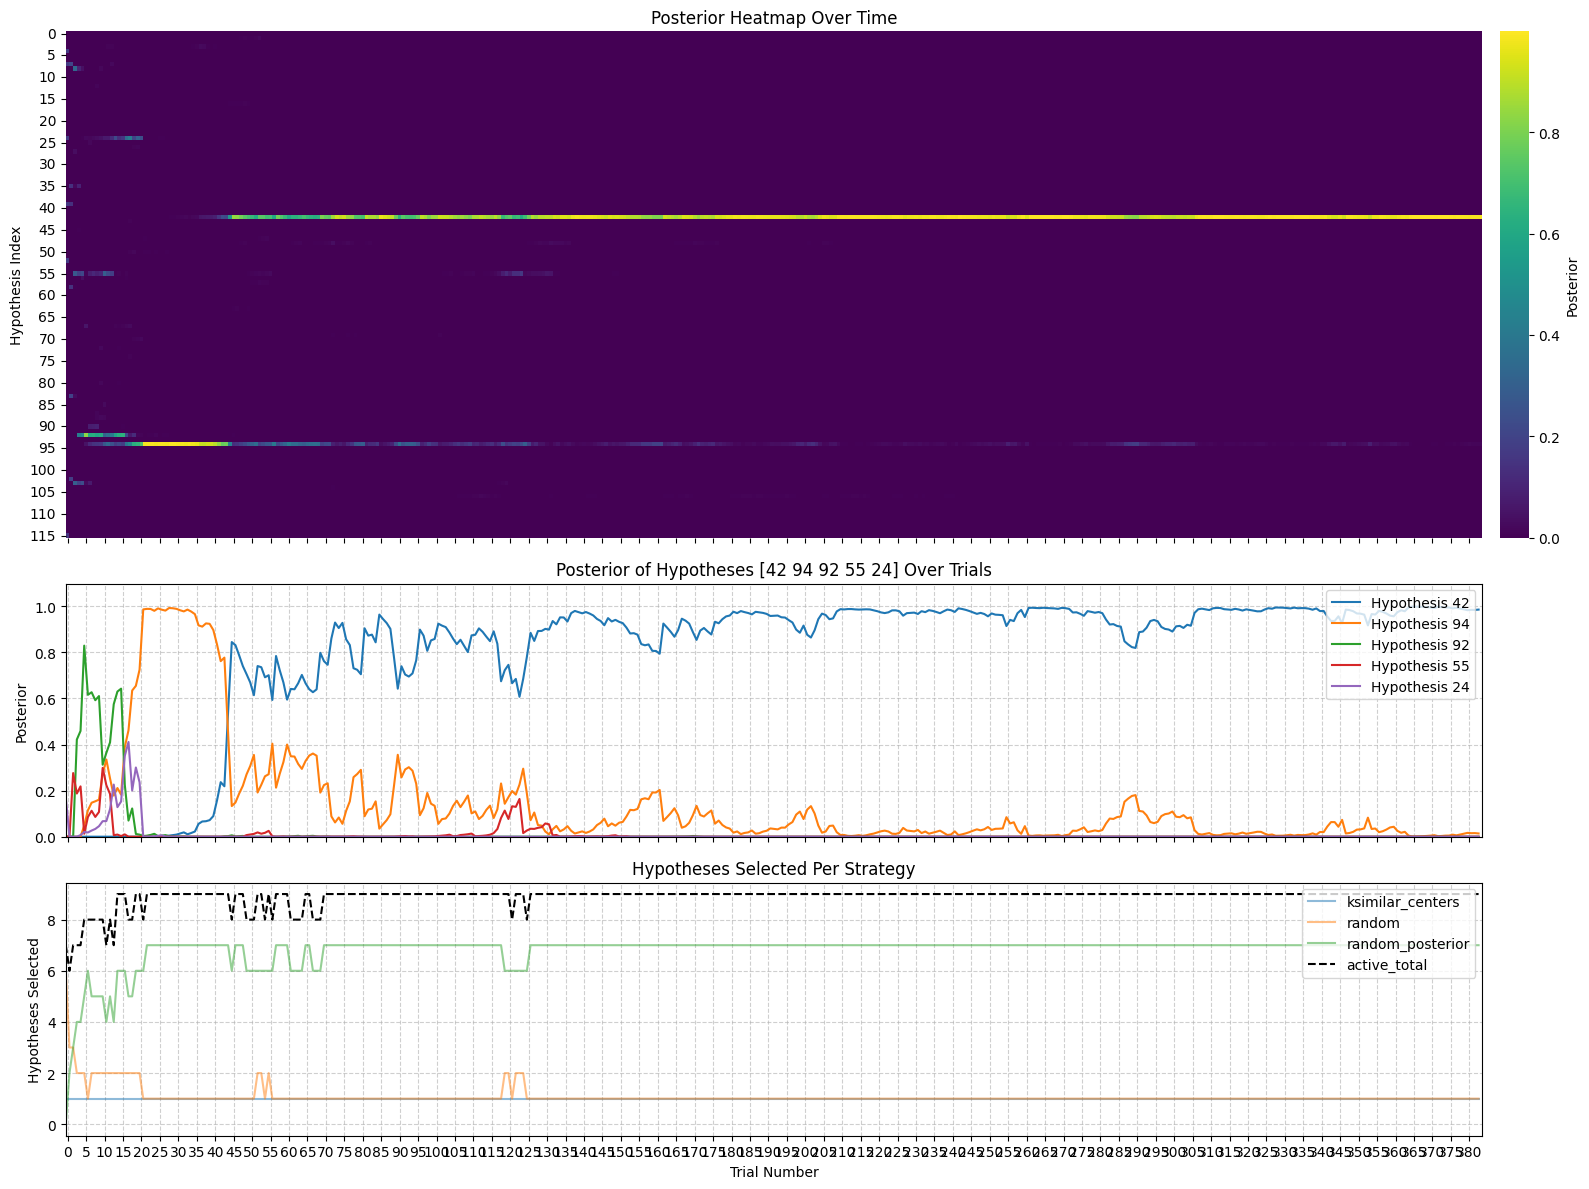

In [51]:
# 画图
import matplotlib.pyplot as plt  # type: ignore[import]
import seaborn as sns  # type: ignore[import]

# 准备数据
posterior_array = np.array(posterior_log).T
n_steps = posterior_array.shape[1]
trials = np.arange(n_steps)
hypo_indices = top5_indices
active_hypos_num_list = [np.argwhere(posterior_log[i]).shape[0] for i in range(len(posterior_log))]

# 根据是否有策略计数日志决定布局
if has_strategy_counts:
    fig, axes = plt.subplots(3, 2, figsize=(16, 12), sharex='col',
                             gridspec_kw={'height_ratios': [2, 1, 1], 'width_ratios': [50, 1]})
    ax_heatmap = axes[0, 0]
    ax_cbar = axes[0, 1]
    ax_line = axes[1, 0]
    ax_count = axes[2, 0]
    axes[1, 1].axis('off')
    axes[2, 1].axis('off')
else:
    fig, axes = plt.subplots(2, 2, figsize=(16, 8), sharex='col',
                             gridspec_kw={'height_ratios': [2, 1], 'width_ratios': [50, 1]})
    ax_heatmap = axes[0, 0]
    ax_cbar = axes[0, 1]
    ax_line = axes[1, 0]
    ax_count = None
    axes[1, 1].axis('off')

# 1. Heatmap
sns.heatmap(posterior_array, cmap="viridis", ax=ax_heatmap, cbar_ax=ax_cbar, cbar_kws={'label': 'Posterior'})
ax_heatmap.set_ylabel("Hypothesis Index")
ax_heatmap.set_title("Posterior Heatmap Over Time")

# 2. Line plot for top hypotheses
max_post_overall = 0
for hypo_index in hypo_indices:
    hypo_posterior_over_time = [posterior[hypo_index] for posterior in posterior_log]
    max_post = max(hypo_posterior_over_time)
    if max_post > max_post_overall:
        max_post_overall = max_post
    ax_line.plot(trials, hypo_posterior_over_time, linestyle='-', label=f'Hypothesis {hypo_index}')

ax_line.set_ylabel('Posterior')
ax_line.set_ylim(0, max_post_overall * 1.1)
ax_line.grid(True, linestyle='--', alpha=0.6)
ax_line.legend(loc='upper right')
ax_line.set_title(f'Posterior of Hypotheses {hypo_indices} Over Trials')

# 3. 每个策略选中的 hypo 数量随 trial 变化（仅在有 strategy_counts_log 时绘制）
if has_strategy_counts and ax_count is not None:
    min_len = min(len(trial_axis), n_steps)
    for name, counts in strategy_counts.items():
        ax_count.plot(trial_axis[:min_len], counts[:min_len], label=f'{name}', alpha=0.5)
    ax_count.plot(trial_axis[:min_len], active_total[:min_len], color='black', linestyle='--', label='active_total')
    ax_count.set_ylabel('Hypotheses Selected')
    ax_count.set_xlabel('Trial Number')
    ax_count.grid(True, linestyle='--', alpha=0.6)
    ax_count.legend(loc='upper right')
    ax_count.set_title('Hypotheses Selected Per Strategy')

# 调整布局
plt.tight_layout()
plt.show()

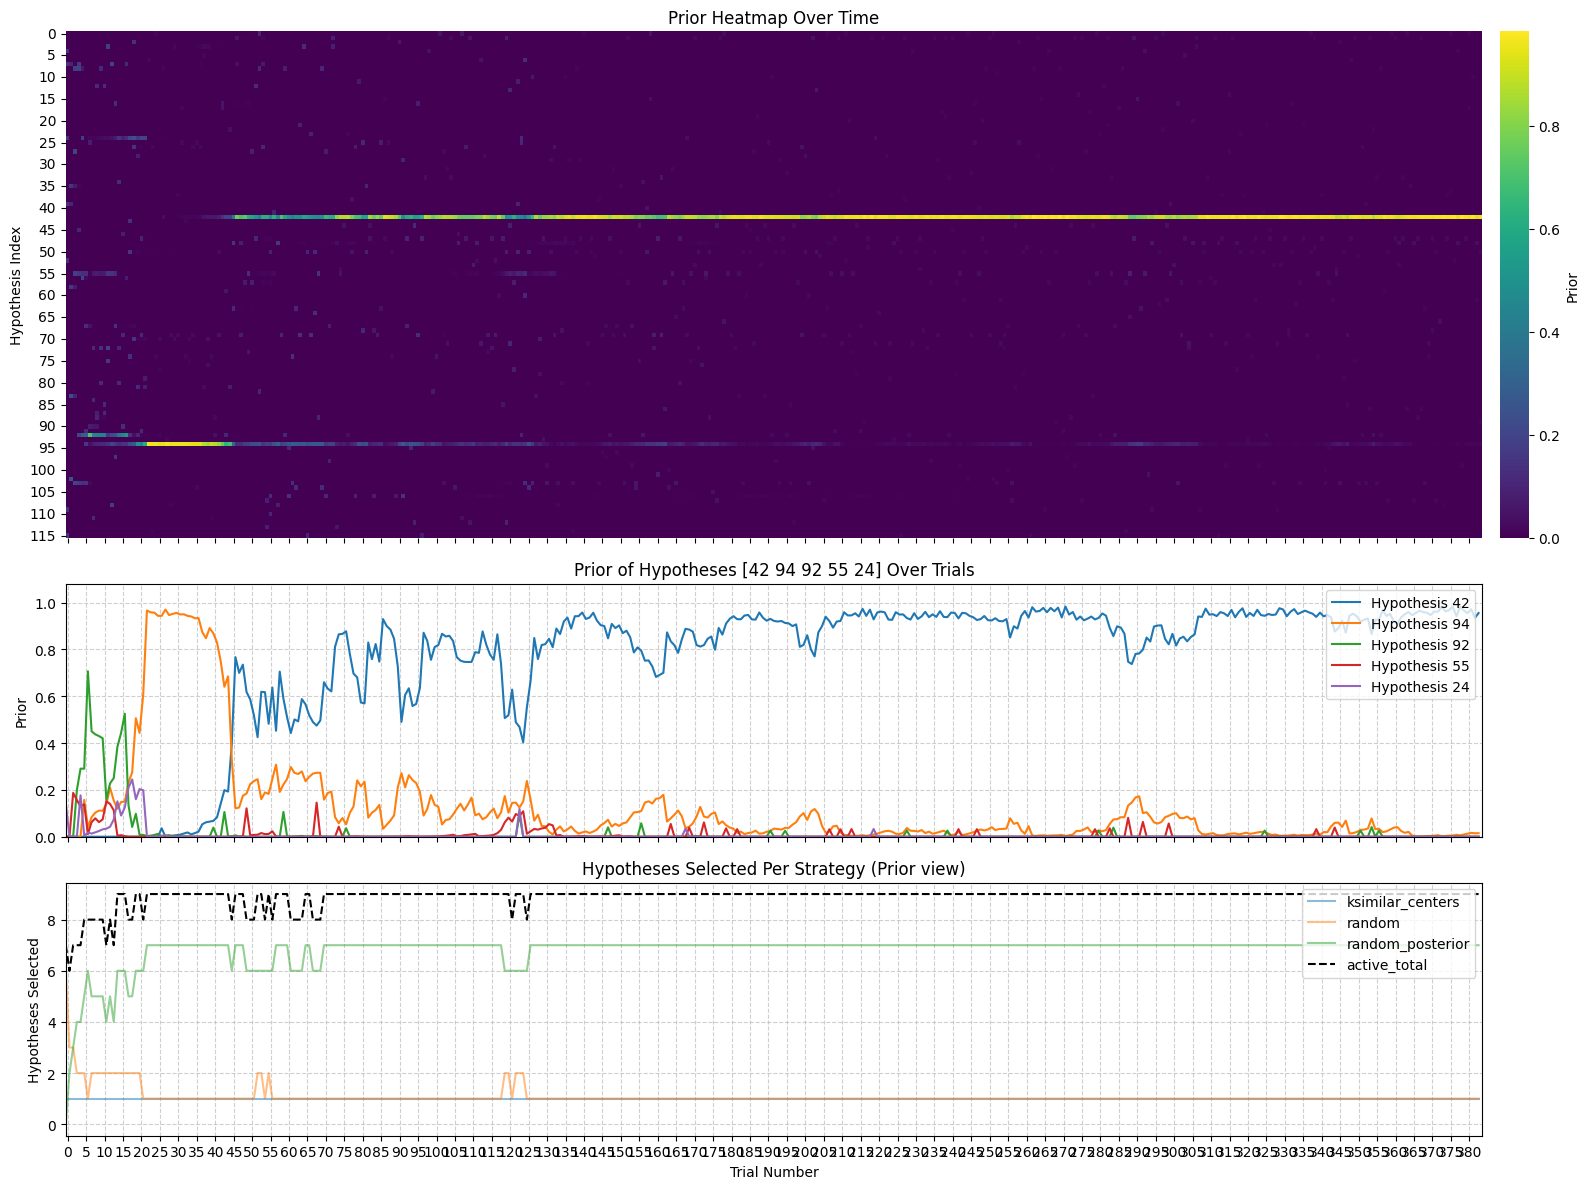

In [52]:
# 仿照 posterior，也画出 prior 的图
prior_array = np.array(prior_log).T
n_steps = prior_array.shape[1]

# 根据是否有策略计数日志决定布局
if has_strategy_counts:
    fig, axes = plt.subplots(3, 2, figsize=(16, 12), sharex='col', 
                             gridspec_kw={'height_ratios': [2, 1, 1], 'width_ratios': [50, 1]})
    ax_heatmap = axes[0, 0]
    ax_cbar = axes[0, 1]
    ax_line = axes[1, 0]
    ax_count = axes[2, 0]
    axes[1, 1].axis('off')
    axes[2, 1].axis('off')
else:
    fig, axes = plt.subplots(2, 2, figsize=(16, 8), sharex='col', 
                             gridspec_kw={'height_ratios': [2, 1], 'width_ratios': [50, 1]})
    ax_heatmap = axes[0, 0]
    ax_cbar = axes[0, 1]
    ax_line = axes[1, 0]
    ax_count = None
    axes[1, 1].axis('off')

# 1. Heatmap
sns.heatmap(prior_array, cmap="viridis", ax=ax_heatmap, cbar_ax=ax_cbar, cbar_kws={'label': 'Prior'})
ax_heatmap.set_ylabel("Hypothesis Index")
ax_heatmap.set_title("Prior Heatmap Over Time")

# 2. Line plot for top hypotheses
max_prior_overall = 0
for hypo_index in hypo_indices:
    hypo_prior_over_time = [prior[hypo_index] for prior in prior_log]
    max_prior = max(hypo_prior_over_time)
    if max_prior > max_prior_overall:
        max_prior_overall = max_prior
    ax_line.plot(trials, hypo_prior_over_time, linestyle='-', label=f'Hypothesis {hypo_index}')
ax_line.set_ylabel('Prior')
ax_line.set_ylim(0, max_prior_overall * 1.1)
ax_line.grid(True, linestyle='--', alpha=0.6)
ax_line.legend(loc='upper right')
ax_line.set_title(f'Prior of Hypotheses {hypo_indices} Over Trials')

# 3. 每个策略选中的 hypo 数量随 trial 变化（仅在有 strategy_counts_log 时绘制）
if has_strategy_counts and ax_count is not None:
    min_len = min(len(trial_axis), n_steps)
    for name, counts in strategy_counts.items():
        ax_count.plot(trial_axis[:min_len], counts[:min_len], label=f'{name}', alpha=0.5)
    ax_count.plot(trial_axis[:min_len], active_total[:min_len], color='black', linestyle='--', label='active_total')
    ax_count.set_ylabel('Hypotheses Selected')
    ax_count.set_xlabel('Trial Number')
    ax_count.grid(True, linestyle='--', alpha=0.6)
    ax_count.legend(loc='upper right')
    ax_count.set_title('Hypotheses Selected Per Strategy (Prior view)')

# 调整布局
plt.tight_layout()
plt.show()